### Training the new model with additional dataset - Larch Casebearer

In [1]:
import pandas as pd
from pathlib import Path

# paths
CSV_PATH = Path(r"C:\Users\rsriram3\Documents\ind_study\data\overall_merged_images.csv")
BASE_DIR = Path(r"C:\Users\rsriram3\Documents\ind_study\data")

# load
df = pd.read_csv(CSV_PATH)
assert "image" in df.columns, "CSV must have a column named 'image'"

# build absolute paths
df["abs_path"] = df["image"].apply(lambda p: (BASE_DIR / Path(str(p).replace("\\","/"))).resolve())
df["exists"] = df["abs_path"].apply(lambda p: p.exists())

# summary
missing = df.loc[~df["exists"], "image"]
print(f"Total rows: {len(df)}")
print(f"Missing files: {len(missing)}")
if len(missing) > 0:
    print("Examples of missing paths:")
    print(missing.head(10).to_string(index=False))


Total rows: 24922
Missing files: 0


In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm
import torchvision.transforms as T
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

c:\Users\rsriram3\Documents\ind_study\test-IIM\shenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path

ROOTS = {
    "vedai": Path("C:/Users/rsriram3/Documents/ind_study/data"),
    "shha":  Path("C:/Users/rsriram3/Documents/ind_study/data"),
    "shhb":  Path("C:/Users/rsriram3/Documents/ind_study/data"),
    "larch": Path("C:/Users/rsriram3/Documents/ind_study/data"),
}

MODEL_NAME   = "tiny_vit_5m_224.dist_in22k_ft_in1k"
IMG_SIZE     = 224
NUM_CLASSES  = 3
BATCH_SIZE   = 16
EPOCHS       = 10
LR           = 2e-4
WEIGHT_DECAY = 0.05
PATIENCE     = 5                 # early stopping patience (epochs)
LABEL_SMOOTH = 0.05              # label smoothing for CE
SEED         = 123
NUM_WORKERS  = 2                 # 0 on Windows if needed
N_SPLITS     = 5                 # stratified K-fold (set to 1 for a single split)


In [3]:
import os, random, math
import numpy as np
import pandas as pd
from pathlib import Path

import torch
from torch import nn, autocast
from torch.utils.data import Dataset, DataLoader
# from torch.cuda.amp import autocast
from torch.amp import GradScaler

import timm
from timm.data import resolve_data_config, create_transform

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image
from tqdm import tqdm

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

c:\Users\rsriram3\Documents\ind_study\test-IIM\shenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [4]:
from IPython.display import display

df = pd.read_csv(CSV_PATH)
assert {"image","label"}.issubset(df.columns), "CSV must have columns: image,label"

def which_ds(p: str) -> str:
    s = str(p).lower().replace("\\","/")
    if "vedai_512" in s or "vedai_1024" in s or "/vedai" in s:
        return "vedai"
    if "shhb" in s or "/shb" in s or "shanghaitech data\\shhb" in s.lower():
        return "shhb"
    if "shha" in s or "/sha" in s or "shanghaitech data\\shha" in s.lower():
        return "shha"
    if "data_set_larch_casebearer" in s or "larch_casebearer" in s or "augmented_images" in s or "/larch/" in s:
        return "larch"
    return "vedai"

def resolve_abs(rel: str) -> Path | None:
    rel_p = Path(str(rel).replace("\\","/"))
    # try inferred root first
    root = ROOTS.get(which_ds(rel_p.as_posix()), ROOTS["vedai"])
    cand = (root / rel_p)
    if cand.exists(): return cand.resolve()
    # last resort: try all roots
    for r in ROOTS.values():
        c = (r / rel_p)
        if c.exists(): return c.resolve()
    return None

df["abs_path"] = df["image"].apply(resolve_abs)
missing = df["abs_path"].isna().sum()
print("Unresolved rows:", missing)
if missing:
    display(df[df["abs_path"].isna()].head(10))
df = df.dropna(subset=["abs_path"]).reset_index(drop=True)
df["label"] = df["label"].astype(int)
df.head(3)


Unresolved rows: 0


,image,label,brightness,edge_density,entropy,abs_path
0,VEDAI_dataset\VEDAI_512\images\00000000_co.png,0,148.686729,0.132713,6.791240,C:\Users\rsriram3\Documents\ind_study\data\VED...
1,VEDAI_dataset\VEDAI_512\images\00000000_ir.png,0,194.854771,0.026806,5.643956,C:\Users\rsriram3\Documents\ind_study\data\VED...
2,VEDAI_dataset\VEDAI_512\images\00000000_ir_tri...,0,181.481246,0.041693,5.920810,C:\Users\rsriram3\Documents\ind_study\data\VED...


In [5]:
counts = df["label"].value_counts().sort_index()
print("Class counts:\n", counts)
print("Class ratios:\n", (counts / counts.sum()).round(4))

Class counts:
 label
0    13983
1     4791
2     6148
Name: count, dtype: int64
Class ratios:
 label
0    0.5611
1    0.1922
2    0.2467
Name: count, dtype: float64


In [6]:
_tmp = timm.create_model('tiny_vit_5m_224.dist_in22k_ft_in1k', pretrained=True, num_classes=NUM_CLASSES)
data_cfg = resolve_data_config(model=_tmp)
print("Resolved input_size:", data_cfg.get("input_size"))

train_tfms = create_transform(**data_cfg, is_training=True)   # includes resize/crop/norm
val_tfms   = create_transform(**data_cfg, is_training=False)  # resize + center crop + norm

Resolved input_size: (3, 224, 224)


In [7]:
class CSVDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, transform=None):
        self.f = frame.reset_index(drop=True)
        self.t = transform
    def __len__(self): return len(self.f)
    def __getitem__(self, i):
        p = Path(self.f.loc[i, "abs_path"])
        y = int(self.f.loc[i, "label"])
        x = Image.open(p).convert("RGB")
        if self.t: x = self.t(x)
        return x, y

In [8]:
class EarlyStopper:
    def __init__(self, patience=PATIENCE, mode="min", min_delta=0.0):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = None
        self.count = 0

    def step(self, value) -> bool:
        if self.best is None:
            self.best = value
            return False
        improved = (value < self.best - self.min_delta) if self.mode == "min" else (value > self.best + self.min_delta)
        if improved:
            self.best = value
            self.count = 0
        else:
            self.count += 1
        return self.count > self.patience


In [9]:
def create_model():
    model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)
    return model.to(device)

def make_loaders(df_train, df_val):
    ds_tr = CSVDataset(df_train, transform=train_tfms)
    ds_va = CSVDataset(df_val,   transform=val_tfms)
    dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
    dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    return dl_tr, dl_va

def train_one_model(df_train, df_val, max_epochs=EPOCHS, run_name="run"):
    dl_tr, dl_va = make_loaders(df_train, df_val)
    model = create_model()
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    # Cosine schedule over epochs (per-step cosine also OK; keep simple here)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
    scaler = GradScaler()

    es = EarlyStopper(patience=PATIENCE, mode="min")
    best_val = float("inf")
    best_state = None

    def run_epoch(loader, train=True):
        if train: model.train()
        else:     model.eval()
        tot_loss, tot, correct = 0.0, 0, 0
        pbar = tqdm(loader, leave=False)
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            with autocast(True):
                logits = model(xb)
                loss = criterion(logits, yb)
            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            tot_loss += loss.item() * xb.size(0)
            pred = logits.argmax(1)
            correct += (pred == yb).sum().item()
            tot += xb.size(0)
        return tot_loss / max(tot,1), correct / max(tot,1)

    for epoch in range(1, max_epochs+1):
        tr_loss, tr_acc = run_epoch(dl_tr, train=True)
        va_loss, va_acc = run_epoch(dl_va, train=False)
        scheduler.step()
        print(f"[{run_name}] epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")
        if va_loss < best_val:
            best_val = va_loss
            best_state = { "state_dict": model.state_dict(),
                           "num_classes": NUM_CLASSES,
                           "img_size": IMG_SIZE }
        if es.step(va_loss):
            print(f"Early stopping at epoch {epoch} (best val loss {best_val:.4f})")
            break

    # Restore best state for evaluation
    if best_state is not None:
        model.load_state_dict(best_state["state_dict"])
    return model, best_state


In [10]:
import torch
from torch.utils.data import DataLoader

NUM_WORKERS = 4        # try 2 if RAM is tight
PREFETCH    = 2
BATCH_SIZE  = 32       # adjust if VRAM limited
MAX_TRAIN_STEPS = 200 # set e.g. 200 for quick feedback, else None
MAX_VAL_STEPS   = 60 # set e.g. 60  for quick feedback, else None

def make_loaders(df_train, df_val):
    ds_tr = CSVDataset(df_train, transform=train_tfms)
    ds_va = CSVDataset(df_val,   transform=val_tfms)
    dl_tr = DataLoader(
        ds_tr, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=True,
        persistent_workers=True, prefetch_factor=PREFETCH
    )
    dl_va = DataLoader(
        ds_va, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True,
        persistent_workers=True, prefetch_factor=PREFETCH
    )
    return dl_tr, dl_va

# One-line device sanity once you create the model in training:
# print("Model device:", next(model.parameters()).device)


In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

TRAIN_ALL_FOLDS = False
labels = df["label"].values
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_models = []
for fold, (tr_idx, va_idx) in enumerate(skf.split(np.zeros(len(labels)), labels), 1):
    df_tr = df.iloc[tr_idx].reset_index(drop=True)
    df_va = df.iloc[va_idx].reset_index(drop=True)

    print(f"\n=== Fold {fold}/{N_SPLITS} | train={len(df_tr)} val={len(df_va)} ===")
    print("train label counts:", df_tr["label"].value_counts().sort_index().to_dict())
    print("val   label counts:", df_va["label"].value_counts().sort_index().to_dict())

    model, best_state = train_one_model(df_tr, df_va, max_epochs=EPOCHS, run_name=f"fold{fold}")
    fold_models.append((model, best_state))

    if not TRAIN_ALL_FOLDS:
        break



=== Fold 1/5 | train=19937 val=4985 ===
train label counts: {0: 11186, 1: 3833, 2: 4918}
val   label counts: {0: 2797, 1: 958, 2: 1230}


  0%|          | 0/624 [00:00<?, ?it/s]

preivious k-fold training 

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

TRAIN_ALL_FOLDS = False  # set True to train all folds

labels = df["label"].values
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_models = []
if __name__ == "__main__":  # important on Windows to allow num_workers>0 in your dataloaders
    for fold, (tr_idx, va_idx) in enumerate(skf.split(np.zeros(len(labels)), labels), 1):
        df_tr = df.iloc[tr_idx].reset_index(drop=True)
        df_va = df.iloc[va_idx].reset_index(drop=True)

        print(f"\n=== Fold {fold}/{N_SPLITS} | train={len(df_tr)} val={len(df_va)} ===")
        print("train label counts:", df_tr["label"].value_counts().sort_index().to_dict())
        print("val   label counts:", df_va["label"].value_counts().sort_index().to_dict())

        model, best_state = train_one_model(df_tr, df_va, max_epochs=EPOCHS, run_name=f"fold{fold}")
        fold_models.append((model, best_state))

        if not TRAIN_ALL_FOLDS:
            break


In [ ]:
# from sklearn.model_selection import StratifiedKFold
# import numpy as np
# from torch.amp import GradScaler
# from torch import nn, autocast
# from tqdm import tqdm

# TRAIN_ALL_FOLDS = False  # True = train all folds; False = first fold only
# labels = df["label"].values
# skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# def train_one_model(df_train, df_val, max_epochs=EPOCHS, run_name="run"):
#     dl_tr, dl_va = make_loaders(df_train, df_val)
#     model = create_model()
#     print("Model device:", next(model.parameters()).device)

#     criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
#     scaler = GradScaler()
#     es = EarlyStopper(patience=PATIENCE, mode="min")
#     best_val = float("inf")
#     best_state = None

#     def run_epoch(loader, train=True):
#         model.train(train)
#         total_loss, correct, total = 0.0, 0, 0
#         step = 0
#         pbar = tqdm(loader, leave=False)
#         for xb, yb in pbar:
#             step += 1
#             xb = xb.to("cuda", non_blocking=True) if torch.cuda.is_available() else xb
#             yb = yb.to("cuda", non_blocking=True) if torch.cuda.is_available() else yb
#             with autocast(True):
#                 logits = model(xb)
#                 loss = criterion(logits, yb)
#             if train:
#                 optimizer.zero_grad(set_to_none=True)
#                 scaler.scale(loss).backward()
#                 scaler.step(optimizer)
#                 scaler.update()
#             total_loss += loss.item() * xb.size(0)
#             correct += (logits.argmax(1) == yb).sum().item()
#             total   += xb.size(0)
#             if train and MAX_TRAIN_STEPS and step >= MAX_TRAIN_STEPS: break
#             if not train and MAX_VAL_STEPS and step >= MAX_VAL_STEPS: break
#         return total_loss / max(total,1), correct / max(total,1)

#     for epoch in range(1, max_epochs+1):
#         tr_loss, tr_acc = run_epoch(dl_tr, train=True)
#         va_loss, va_acc = run_epoch(dl_va, train=False)
#         scheduler.step()
#         print(f"[{run_name}] epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")
#         if va_loss < best_val:
#             best_val = va_loss
#             best_state = {"state_dict": model.state_dict(), "num_classes": NUM_CLASSES, "img_size": IMG_SIZE}
#         if es.step(va_loss):
#             print(f"Early stopping at epoch {epoch} (best val loss {best_val:.4f})")
#             break

#     if best_state is not None:
#         model.load_state_dict(best_state["state_dict"])
#     return model, best_state

# fold_models = []
# if __name__ == "__main__":
#     for fold, (tr_idx, va_idx) in enumerate(skf.split(np.zeros(len(labels)), labels), 1):
#         df_tr = df.iloc[tr_idx].reset_index(drop=True)
#         df_va = df.iloc[va_idx].reset_index(drop=True)

#         print(f"\n=== Fold {fold}/{N_SPLITS} | train={len(df_tr)} val={len(df_va)} ===")
#         print("train label counts:", df_tr["label"].value_counts().sort_index().to_dict())
#         print("val   label counts:", df_va["label"].value_counts().sort_index().to_dict())

#         model, best_state = train_one_model(df_tr, df_va, max_epochs=EPOCHS, run_name=f"fold{fold}")
#         fold_models.append((model, best_state))

#         if not TRAIN_ALL_FOLDS:
#             break



=== Fold 1/5 | train=19937 val=4985 ===
train label counts: {0: 11186, 1: 3833, 2: 4918}
val   label counts: {0: 2797, 1: 958, 2: 1230}
Model device: cuda:0


  0%|          | 0/624 [00:00<?, ?it/s]

### COMPLETElY CHANGING THE TRAINING

In [2]:
# Cell 1: config & imports (edit paths to match your environment)
from pathlib import Path
import os
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autocast
from torch.amp import GradScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from PIL import Image
from timm import create_model
import random

# === EDIT THESE PATHS ===
CSV_PATH = Path(r"C:\Users\rsriram3\Documents\ind_study\data\overall_merged_images.csv")# your merged csv
ROOT_DIR   = Path(r"C:\Users\rsriram3\Documents\ind_study\data")  # base path to prepend to 'image' column entries
OUTPUT_DIR = ROOT_DIR / "results" # where to put models/figures/folds
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoints"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# === HYPERPARAMS (as in text file) ===
BATCH_SIZE    = 32
EPOCHS        = 5
LR            = 3e-5
WEIGHT_DECAY  = 5e-3
ALPHA_MIXUP   = 0.2
USE_MIXUP     = False           # set True to enable mixup (matches text flow)
NUM_FOLDS     = 5
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATIENCE      = 3               # early stopping patience used in text
LABEL_SMOOTH  = 0.1
SEED          = 173
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

print("Device:", DEVICE)
print("CSV:", CSV_PATH)
print("ROOT_DIR:", ROOT_DIR)


Device: cuda
CSV: C:\Users\rsriram3\Documents\ind_study\data\overall_merged_images.csv
ROOT_DIR: C:\Users\rsriram3\Documents\ind_study\data


In [3]:
# Cell 2: dataset, collate, mixup (copied/adjusted from test_text.txt)  :contentReference[oaicite:1]{index=1}
import torch

class SharedHeadDataset(Dataset):
    def __init__(self, csv_path, root_dir):
        self.data = pd.read_csv(csv_path)
        self.root_dir = Path(root_dir)
        self.transform = torch.nn.Sequential()  # placeholder; we will use PIL->tensor manually

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = self.root_dir / row['image']
        image = Image.open(img_path).convert("RGB")
        # Resize + ToTensor + Normalize: use simple resize & to-tensor here (the original text used Resize->ToTensor)
        image = image.resize((224, 224))
        image = np.array(image).astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2,0,1).contiguous()  # C,H,W

        aux = torch.tensor([
            float(row['brightness']), 
            float(row['edge_density']), 
            float(row['entropy'])
        ], dtype=torch.float32)
        
        label = torch.tensor(int(row['label']), dtype=torch.long)
        return image, aux, label

def collate_fun(batch):
    images, auxs, labels = zip(*batch)
    images = torch.stack(images)    # (B,3,224,224)
    auxs   = torch.stack(auxs)      # (B,3)
    labels = torch.tensor(labels, dtype=torch.long)
    return images, auxs, labels

def mixup_data(x, aux, y, alpha=ALPHA_MIXUP):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_aux = lam * aux + (1 - lam) * aux[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, mixed_aux, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [4]:
# Cell 3: ExtendedModel + LabelSmoothingCrossEntropy (from text)  :contentReference[oaicite:2]{index=2}
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        log_probs = F.log_softmax(pred, dim=-1)
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(self.smoothing / (pred.size(1) - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), confidence)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

# ExtendedModel: uses timm backbone, aux head, fused head (as in test_text)
class ExtendedModel(nn.Module):
    def __init__(self, backbone_name, num_classes=3):   # set 3 classes for your new dataset
        super().__init__()
        self.backbone = create_model(backbone_name, pretrained=True, num_classes=0, global_pool="avg")
        self.aux_head = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.head = nn.Sequential(
            nn.LayerNorm(self.backbone.num_features + 16),
            nn.Linear(self.backbone.num_features + 16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, aux):
        # x: (B,3,H,W)
        image_features = self.backbone(x)  # (B, D)
        aux_features = self.aux_head(aux)  # (B, 16)
        combined = torch.cat([image_features, aux_features], dim=1)
        return self.head(combined)


In [5]:
# Cell 4: eval, plotting and EarlyStopping (copied from text)  :contentReference[oaicite:3]{index=3}
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, aux, labels in dataloader:
            images, aux, labels = images.to(device), aux.to(device), labels.to(device)
            outputs = model(images, aux)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    print(classification_report(all_labels, all_preds, digits=4))
    return acc, f1, cm, all_preds, all_labels

def plot_metrics(train_accs, val_accs, model_name, save_path):
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(8,5))
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title(f"Accuracy vs Epoch - {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.savefig(save_path / f"{model_name}_accuracy.png")
    plt.close()

def plot_confusion_matrix(cm, model_name, show=True):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix: {model_name}")
    if show:
        plt.show()


In [6]:
# Cell 5: EarlyStopping + train_model (matches test_text.txt training loop)  :contentReference[oaicite:4]{index=4}
class EarlyStopping:
    def __init__(self, patience=3, delta=0.001, verbose=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.verbose = verbose

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model, path):
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

# train_model: uses ExtendedModel, optional mixup, label smoothing CE, GradScaler, scheduler, early stopping
def train_model(model_name, train_csv, val_csv, root_dir, save_path,
                device=DEVICE, use_mixup=USE_MIXUP, label_smoothing=LABEL_SMOOTH):
    train_ds = SharedHeadDataset(train_csv, root_dir)
    val_ds   = SharedHeadDataset(val_csv, root_dir)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fun)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, collate_fn=collate_fun)

    model = ExtendedModel(model_name, num_classes=3).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=1)
    scaler = GradScaler()

    early_stopper = EarlyStopping(patience=PATIENCE, delta=0.001, verbose=True)
    early_stop_path = CHECKPOINT_DIR / f"{model_name}_earlystop_best.pth"

    criterion = LabelSmoothingCrossEntropy(smoothing=label_smoothing)

    train_accs, val_accs, train_losses, val_losses = [], [], [], []

    for epoch in range(EPOCHS):
        model.train()
        correct, total = 0, 0
        total_train_loss = 0.0
        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for images, aux, labels in progress:
            images, aux, labels = images.to(device), aux.to(device), labels.to(device)
            optimizer.zero_grad()

            if use_mixup:
                images, aux_features, targets_a, targets_b, lam = mixup_data(images, aux, labels, ALPHA_MIXUP)
                mixup_mode = True
            else:
                aux_features = aux
                mixup_mode = False

            with autocast(device_type=str(device).split(':')[0] if device.type=='cuda' else 'cpu'):
                outputs = model(images, aux_features)
                if mixup_mode:
                    loss = mixup_criterion(F.cross_entropy, outputs, targets_a, targets_b, lam)
                else:
                    loss = criterion(outputs, labels)

            total_train_loss += loss.item()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            progress.set_postfix(loss=loss.item(), acc=correct / total)

        train_acc = correct / total
        train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for images, aux, labels in val_loader:
                images, aux, labels = images.to(device), aux.to(device), labels.to(device)
                outputs = model(images, aux)
                total_val_loss += F.cross_entropy(outputs, labels).item()  # plain CE for validation

        val_loss = total_val_loss / len(val_loader)
        val_acc, val_f1, cm, _, _ = evaluate_model(model, val_loader, device)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        early_stopper(val_loss, model, early_stop_path)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

        scheduler.step(epoch)
        gc.collect()

    # Save last state and reload best if early stopped
    torch.save(model.state_dict(), save_path)
    if early_stopper.early_stop:
        model.load_state_dict(torch.load(early_stop_path))

    return model, train_accs, val_accs, train_losses, val_losses


Dataset size after dropna: (24922, 5)

=== Fold 1 ===


Epoch 1/5: 100%|██████████| 624/624 [09:33<00:00,  1.09it/s, acc=0.876, loss=2.07] 


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2797
           1     1.0000    1.0000    1.0000       958
           2     1.0000    1.0000    1.0000      1230

    accuracy                         1.0000      4985
   macro avg     1.0000    1.0000    1.0000      4985
weighted avg     1.0000    1.0000    1.0000      4985



Epoch 2/5: 100%|██████████| 624/624 [07:02<00:00,  1.48it/s, acc=0.999, loss=0.419]


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2797
           1     1.0000    1.0000    1.0000       958
           2     1.0000    1.0000    1.0000      1230

    accuracy                         1.0000      4985
   macro avg     1.0000    1.0000    1.0000      4985
weighted avg     1.0000    1.0000    1.0000      4985

EarlyStopping: 1/3


Epoch 3/5: 100%|██████████| 624/624 [07:04<00:00,  1.47it/s, acc=0.999, loss=0.422]


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2797
           1     1.0000    1.0000    1.0000       958
           2     1.0000    1.0000    1.0000      1230

    accuracy                         1.0000      4985
   macro avg     1.0000    1.0000    1.0000      4985
weighted avg     1.0000    1.0000    1.0000      4985

EarlyStopping: 2/3


Epoch 4/5: 100%|██████████| 624/624 [07:02<00:00,  1.48it/s, acc=1, loss=2.75] 


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2797
           1     1.0000    1.0000    1.0000       958
           2     1.0000    1.0000    1.0000      1230

    accuracy                         1.0000      4985
   macro avg     1.0000    1.0000    1.0000      4985
weighted avg     1.0000    1.0000    1.0000      4985

EarlyStopping: 3/3
Early stopping triggered.
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2797
           1     1.0000    1.0000    1.0000       958
           2     1.0000    1.0000    1.0000      1230

    accuracy                         1.0000      4985
   macro avg     1.0000    1.0000    1.0000      4985
weighted avg     1.0000    1.0000    1.0000      4985



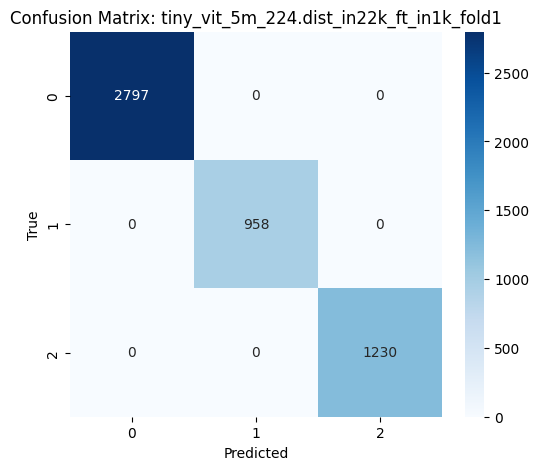


=== Fold 2 ===


Epoch 1/5: 100%|██████████| 624/624 [09:16<00:00,  1.12it/s, acc=0.899, loss=0.598]


              precision    recall  f1-score   support

           0     0.9996    0.9996    0.9996      2797
           1     1.0000    0.9990    0.9995       958
           2     0.9992    1.0000    0.9996      1230

    accuracy                         0.9996      4985
   macro avg     0.9996    0.9995    0.9996      4985
weighted avg     0.9996    0.9996    0.9996      4985



Epoch 2/5: 100%|██████████| 624/624 [06:56<00:00,  1.50it/s, acc=0.999, loss=0.428]


              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998      2797
           1     1.0000    0.9990    0.9995       958
           2     1.0000    1.0000    1.0000      1230

    accuracy                         0.9998      4985
   macro avg     0.9999    0.9997    0.9998      4985
weighted avg     0.9998    0.9998    0.9998      4985

EarlyStopping: 1/3


Epoch 3/5:  88%|████████▊ | 548/624 [06:00<00:49,  1.52it/s, acc=1, loss=0.428]


KeyboardInterrupt: 

In [7]:
# Cell 6: CV loop + saving folds + running train_model (matches text flow)  :contentReference[oaicite:5]{index=5}
df = pd.read_csv(CSV_PATH)
# drop rows missing required columns (text does this)
df = df.dropna(subset=['image', 'label', 'brightness', 'edge_density', 'entropy']).reset_index(drop=True)

print("Dataset size after dropna:", df.shape)
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
FOLDS_DIR = OUTPUT_DIR / "folds"
FOLDS_DIR.mkdir(parents=True, exist_ok=True)

# select backbone per text (tiny_vit index 3 in text)
model_configs = [
    ("swin_small_patch4_window7_224.ms_in1k", "swin_model.pth"),
    ("coatnet_1_rw_224.sw_in1k", "coatnet_model.pth"),
    ("convnext_small.fb_in1k", "convnext_model.pth"),
    ("tiny_vit_5m_224.dist_in22k_ft_in1k", "tiny_vit_model.pth"),
    ("edgenext_xx_small.in1k", "edgenext_xx_model.pth"),
]
model_id = 3
model_name = model_configs[model_id][0]
history = model_configs[model_id][1]

save_path = OUTPUT_DIR / "models" / history.split('.')[0]
save_path.mkdir(parents=True, exist_ok=True)
plot_save_path = OUTPUT_DIR / "figures" / history.split('.')[0]
plot_save_path.mkdir(parents=True, exist_ok=True)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['label'])):
    print(f"\n=== Fold {fold + 1} ===")
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df   = df.iloc[val_idx].reset_index(drop=True)

    train_fold_path = FOLDS_DIR / f"{history}_train_fold_{fold+1}.csv"
    val_fold_path   = FOLDS_DIR / f"{history}_val_fold_{fold+1}.csv"
    train_df.to_csv(train_fold_path, index=False)
    val_df.to_csv(val_fold_path, index=False)

    model_save_path = save_path / f"{model_name}_fold{fold+1}.pth"
    model, train_accs, val_accs, train_losses, val_losses = train_model(
        model_name, train_fold_path, val_fold_path, ROOT_DIR, model_save_path
    )

    plot_metrics(train_accs, val_accs, f"{model_name}_fold{fold+1}", plot_save_path)
    # Optionally show final confusion matrix
    _, _, cm, _, _ = evaluate_model(model, DataLoader(SharedHeadDataset(val_fold_path, ROOT_DIR),
                                                       batch_size=BATCH_SIZE, collate_fn=collate_fun), DEVICE)
    plot_confusion_matrix(cm, f"{model_name}_fold{fold+1}")
